In [49]:
!nvidia-smi

Sun Jul  3 20:44:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    35W / 250W |   7233MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import Libraries

In [50]:
# import libraries and mount drive 
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Licenta/Demo_Licenta

import os
import time
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 15)
plt.rcParams["axes.grid"] = False
import IPython.display as display
from tqdm.notebook import tqdm
import PIL.Image
import tensorflow as tf
from tensorflow import keras

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Licenta/Demo_Licenta


### Data Preprocessing

In [51]:
def tensor_to_image(tensor):

  # multiply by 255 so that we have ranged from 0 to 255 instead of from 0 to 1 
  tensor = tensor * 255

  # convert to uint8 numpy array
  tensor = np.array(tensor, dtype = np.uint8)

  # if the tensor has more than 3 dimensions
  if np.ndim(tensor) > 3:
    # if we're dealing with a single example we can ignore the first dimension
    if tensor.shape[0] == 1:
      tensor = tensor[0]
    # in this case we're dealing with multiple examples
    elif tensor.shape[0] != 1:
      raise Exception("tensor.shape[0] != 1")
      
  # convert to image from uint8 numpy array and return result
  return PIL.Image.fromarray(tensor)

In [52]:
def load_img(image_path):

  # read file from path
  loaded_img = tf.io.read_file(image_path)

  # detects whether an image is a BMP, GIF, JPEG, or PNG, and performs the  appropriate operation to convert the input bytes string into a Tensor of type dtype
  loaded_img = tf.image.decode_image(contents=loaded_img, channels=3)

  # convert to float32 datatype
  loaded_img = tf.image.convert_image_dtype(loaded_img, tf.float32)
  
  return loaded_img

In [53]:
def resize_image(img, max_dim = 512):

  # convert shape to float datatype
  img_shape = tf.cast(tf.shape(img), tf.float32)

  # take only the height and the width
  img_shape = img_shape[:-1]

  # get the maximum dimension of given image 
  max_img_dim = max(img_shape)

  # the new shape of the image will be so that the maximum image dimension is max_dim and the other dimension is scaled according to max_dim
  new_shape = tf.cast((img_shape * max_dim)/max_img_dim, tf.int32)

  # resize the image
  resized_img = tf.image.resize(img, new_shape)

  # add a new axis to the image 
  resized_img = resized_img[tf.newaxis, :]
  
  return resized_img

In [54]:
# @title Load content & style images  { display-mode: "form" }

# get url of content and style image from user
base_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/d/de/Casa_Mil%C3%A0%2C_general_view.jpg/800px-Casa_Mil%C3%A0%2C_general_view.jpg'  # @param {type:"string"}
style_reference_image_url = 'https://d26jxt5097u8sr.cloudfront.net/s3fs-public/Full_matisse2.jpg'  # @param {type:"string"}

# download content and style images from a URL
base_image_path = tf.keras.utils.get_file(origin=base_image_url)
style_reference_image_path = tf.keras.utils.get_file(origin=style_reference_image_url)

(-0.5, 511.5, 415.5, -0.5)

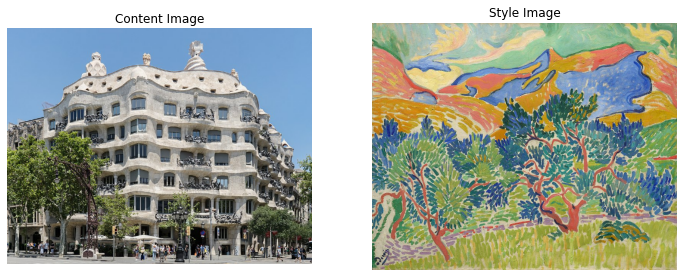

In [55]:
# load and resize images
base_image = resize_image(load_img(base_image_path), max_dim = 512)
style_image = resize_image(load_img(style_reference_image_path), max_dim = 512)

# plot images
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1); plt.imshow(tf.squeeze(base_image, axis=0)); plt.title("Content Image"); plt.axis("off")
plt.subplot(1, 2, 2); plt.imshow(tf.squeeze(style_image, axis=0)); plt.title("Style Image"); plt.axis("off")

In [56]:
# @title Choose the content & style layers and their weights  { display-mode: "form" }

# get content layer names, remove unnecessary white spaces and convert to list
content_layers_names = 'block5_conv2'  # @param {type:"string"}
content_layers_names = content_layers_names.replace(" ", "")
content_layers_names = content_layers_names.split(",")

# get content layer weights, remove unnecessary white spaces and convert to list
content_layers_weights = "1" #@param {type:"string"}
content_layers_weights = content_layers_weights.replace(" ", "")
content_layers_weights = content_layers_weights.split(",")
content_layers_weights = list(map(float, content_layers_weights))

# get style layer names, remove unnecessary white spaces and convert to list
style_layers_names = 'block1_conv1, block2_conv1, block3_conv1, block4_conv1, block5_conv1'  # @param {type:"string"}
style_layers_names = style_layers_names.replace(" ", "")
style_layers_names = style_layers_names.split(",")

# get style layer weights, remove unnecessary white spaces and convert to list
style_layers_weights = "0.2, 0.2, 0.2, 0.2, 0.2" #@param {type:"string"}
style_layers_weights = style_layers_weights.replace(" ", "")
style_layers_weights = style_layers_weights.split(",")
style_layers_weights = list(map(float, style_layers_weights))

### Create model

In [57]:
def get_layer_outputs(layer_names):

  # load vgg model
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  
  # set model as not trainable
  vgg.trainable = False

  # get corresponding outputs for layers in layer_names
  outputs = [vgg.get_layer(layer_name).output for layer_name in layer_names]

  # create the model
  model = tf.keras.Model([vgg.input], outputs)
  return model

In [58]:
# get outputs for given content and style layers and set model as  not trainable
vgg_layers_outputs = get_layer_outputs(style_layers_names + content_layers_names)
vgg_layers_outputs.trainable = False

### Define auxiliary functions

In [59]:
# compute the gram matrix 
def gram_matrix(x):
  return tf.linalg.einsum('bijc,bijd->bcd', x, x)

In [60]:
def feature_extractor(inputs, style_layers, vgg):

  inputs = inputs * 255

  # preprocess the input so that it can be applied to vgg
  preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)

  # get vgg outputs 
  outputs = vgg(preprocessed_input)

  # get the number of style layers
  num_style_layers = len(style_layers)

  # get style layers outputs 
  style_layers_outputs = outputs[:num_style_layers]
  # get content layer outputs 
  content_layers_outputs = outputs[num_style_layers:]

  # compute gram matrix of style layers outputs
  style_layers_outputs = [gram_matrix(style_output)
                   for style_output in style_layers_outputs]

  return content_layers_outputs, style_layers_outputs

### Define losses



In [61]:
# compute style loss with or without normalization
def compute_style_loss(style_outputs, style_targets, style_weights, normalize = False):

  # initialize empty list to store layer losses 
  loss = []

  for style_output, style_target, style_weight in zip(style_outputs, style_targets, style_weights):
    # compute layer loss
    layer_loss = style_weight * tf.reduce_mean(tf.square(style_output-style_target))
    # if normalization is set to true also multiply by the normalization factor 
    if normalize == True:
      factor = tf.cast(2 * tf.shape(style_output)[1] * tf.shape(style_output)[2], tf.float32)
      layer_loss /= factor**2
    loss.append(layer_loss)
    
  # add layer losses 
  return tf.add_n(loss)

In [62]:
# compute content loss with or without normalization
def compute_content_loss(content_outputs, content_targets, content_weights, normalize = False):
  # initialize empty list to store layer losses 
  loss = []
  for content_output, content_target, content_weight in zip(content_outputs, content_targets, content_weights):
    # compute layer loss
    layer_loss = 1/2 * content_weight * tf.reduce_mean(tf.square(content_output - content_target))
    # if normalization is set to true also multiply by the normalization factor 
    if normalize == True:
      factor =  tf.cast(tf.shape(content_output)[1] * tf.shape(content_output)[2], tf.float32)
      layer_loss /= factor
    loss.append(layer_loss)
  # add layer losses 
  return tf.add_n(loss)

In [63]:
# compute total loss with and without total variation loss 
def total_loss(style_loss, content_loss, total_variation_loss = None,
               style_weight = 1e-2, content_weight = 1e4, total_variation_weight = 30):
  if total_variation_loss == None:
    loss = style_weight * style_loss + content_weight * content_loss
  else:
    loss = style_weight * style_loss + content_weight * content_loss + total_variation_weight * total_variation_loss
  return loss

### Define optimizer

In [64]:
optimizer = tf.optimizers.Adam(learning_rate = 0.02, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

### Train

In [65]:
# initialize combination image 
combination_image = tf.Variable(base_image)

In [66]:
# get style layers outputs of style image
_, style_layer_targets = feature_extractor(style_image, style_layers_names, vgg_layers_outputs)
# get content layers outputs of content  image
content_layer_targets, _ = feature_extractor(base_image, style_layers_names, vgg_layers_outputs)

In [67]:
beta = 1e-2 # style weight
alpha = 1e4 # content weight

In [68]:
@tf.function()
def train_step(image, variation_loss = False):
  with tf.GradientTape() as tape:
    # get content layers outputs and style layers outputs
    content_layers_outputs, style_layers_outputs = feature_extractor(image, style_layers_names, vgg_layers_outputs)
    # compute the style loss, content loss, total variation loss and then the total loss
    style_loss = compute_style_loss(style_layers_outputs, style_layer_targets, style_layers_weights, True)
    content_loss = compute_content_loss(content_layers_outputs, content_layer_targets, content_layers_weights, True)
    total_variation_loss = tf.image.total_variation(image)
    if variation_loss == True:
      loss = total_loss(style_loss, content_loss, total_variation_loss, 1e-2, 1e4, 30)
    else:
      loss = total_loss(style_loss, content_loss, None, 1e-2, 1e4, 30)
  # compute the grads with respect to the loss 
  grads = tape.gradient(loss, image)
  # apply grads to image 
  optimizer.apply_gradients([(grads, image)])
  # clip image values to a min of 0 and a max of 1
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

In [69]:
# define the number of steps 
step_num = 1000
# start measuring time
start = time.time()
for i in tqdm(range(step_num)):
  # apply train_step function to combination image 
  train_step(combination_image)
  # every 100 train steps, print the train step number and show image 
  if i % 100 == 0:
    print(f"train step: {i}")
    display.display(tensor_to_image(combination_image))
# end measuring time
end = time.time()
# print execution time
print(f"execution time: {end-start}")

Output hidden; open in https://colab.research.google.com to view.

### Plot & save results

(-0.5, 511.5, 397.5, -0.5)

<Figure size 1080x1080 with 0 Axes>

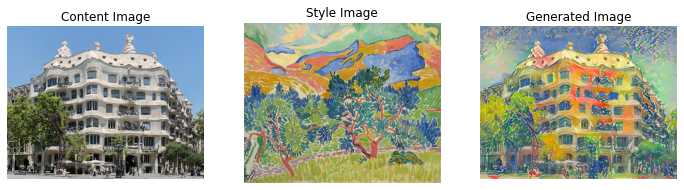

In [70]:
# plot the content image, style image and resulted combination image side by side
plt.figure()
plt.figure(figsize=(12, 12))
plt.subplot(131); plt.imshow(tf.squeeze(base_image, axis=0)); plt.title("Content Image"); plt.axis("off")
plt.subplot(132); plt.imshow(tf.squeeze(style_image, axis=0)); plt.title("Style Image"); plt.axis("off")
plt.subplot(133); plt.imshow(tensor_to_image(combination_image)); plt.title("Generated Image"); plt.axis("off")

In [71]:
# save final image to drive
import uuid
save_path = 'outputs/NST/'
file_name = f'nst_output_{uuid.uuid4()}.jpg'
full_path = os.path.join(save_path, file_name)
tensor_to_image(combination_image).save(full_path)

# save final image to computer 
from google.colab import files
files.download(full_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>